In [1]:
import numpy as np
from scipy.stats import binom, beta
from statsmodels.distributions import ECDF
import matplotlib.pyplot as plt

# Binomial Distribution

The binomial distribution gives the probability of observing $k$ successes in a sequence of $n$ trials, where the probability of success in any trial is $p$.

$$ P\left(k\,|\,n,p\right) = \binom{n}{k}\, p^k\, \left(1 - p\right)^{n-k} $$

For example, let's say we flip 100 coins. What's the probability that exactly 50 of them are heads?

In [2]:
n = 100 # Number of trials
p = 0.5 # Probability of success
k = 50  # Number of successes

binom(n, p).pmf(k) # Probability of k successes, given n trials and probability of success p

0.07958923738717888

We can plot this for a range of $k$'s to see the shape of the distribution.

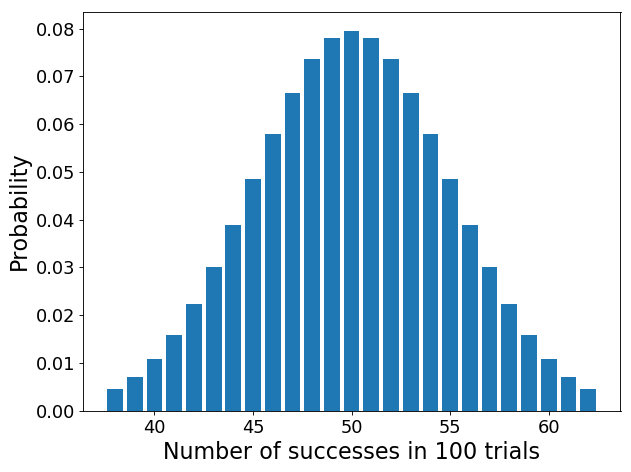

In [3]:
x = np.arange(38, 63)
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(x, binom(n, p).pmf(x), color='tab:blue')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(f'Number of successes in {n} trials', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.tight_layout()

# Beta Distribution

We usually have a slightly different problem to the above. We often know $n$ and $k$ and would like to estimate $p$. 

For example, if we send an email to 100 customers and 50 convert, how confident should we be that the conversion rate is 50%?

We saw above that if the true conversion rate is 50%, the probability of observing exactly 50 conversions in 100 customers is roughly 8%. However, if the true conversion rate is 45%, we'd still have a 5% chance of seeing exactly 50 conversions.

In [4]:
binom(n=100, p=0.45).pmf(50)

0.04815197149809314

By fixing the number of customers (trials) and conversions (successes), and varying the conversion rate (probability of success), we can check which values are most consistent with the observed data.

In [5]:
ps = np.linspace(0.35, 0.65, num=15)
P = np.array([binom(n=100, p=pi).pmf(50) for pi in ps])

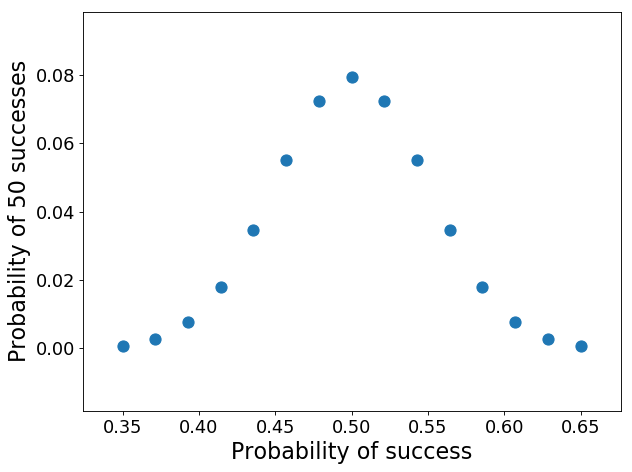

In [6]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(ps, P, color='tab:blue', s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Probability of success', fontsize=20)
plt.ylabel(f'Probability of {k} successes', fontsize=20)
plt.tight_layout()

Not surprisingly, the most likely conversion rate is 50%, but there's clearly a range of conversion rates consistent with the data.

After normalizing, the distribution above is known at the beta distribution. It is a distribution of probabilities. 

$$ P\left(p\,|\,\alpha, \beta\right) = \frac{p^{\alpha-1}\left(1-p\right)^{\beta-1}}{B\left(\alpha, \beta\right)} $$

where $\alpha=k+1$, $\beta=n-k+1$, and $B\left(\alpha, \beta\right)$ is the beta function which normalizes the distribution.

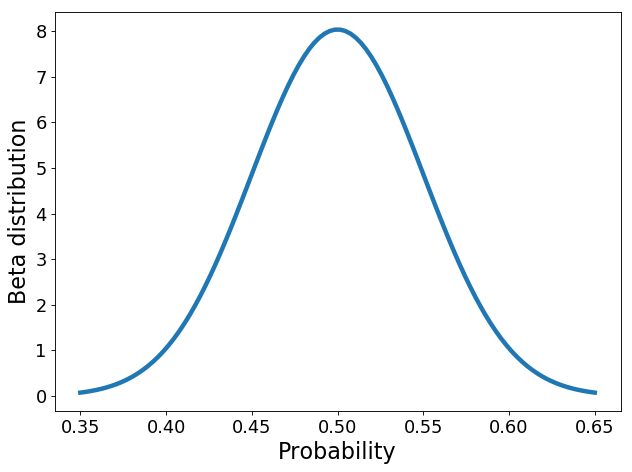

In [7]:
ps = np.linspace(0.35, 0.65, num=100)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(ps, beta(a=k+1, b=n-k+1).pdf(ps), color='tab:blue', lw=4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Probability', fontsize=20)
plt.ylabel('Beta distribution', fontsize=20)
plt.tight_layout()

# A/B Test

We can use the beta distribution to perform an A/B test.

Suppose we have a treatment group with 10,000 customers, and a control group with 7,000 customers. When our campaign finishes, we find 200 conversions in the treatment group and 120 in the control group.

In [8]:
n_a = 10000
n_b = 7000
ns_a = 200
ns_b = 120

print(ns_a / n_a)
print(ns_b / n_b)

0.02
0.017142857142857144


It seems that our campaign had a positive impact on the conversion rate. We can use the beta distribution to be more precise.

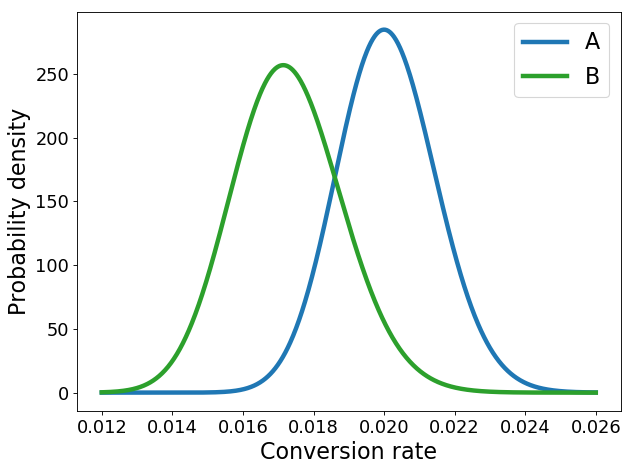

In [9]:
ps = np.linspace(0.012, 0.026, num=1000)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(ps, beta(a=ns_a+1, b=n_a-ns_a+1).pdf(ps), color='tab:blue',  lw=4, label='A')
plt.plot(ps, beta(a=ns_b+1, b=n_b-ns_b+1).pdf(ps), color='tab:green', lw=4, label='B')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Conversion rate', fontsize=20)
plt.ylabel('Probability density', fontsize=20)
plt.legend(prop={'size': 20})
plt.tight_layout()

This looks promising, but there is clearly some overlap between the plausible conversion rates for the treatment and control groups. We can quantify this overlap by sampling from the distributions. Below we calculate the probability that the conversion rate for the treatment group is larger than the control group, given the observed data. 

In [10]:
a_samples = np.random.beta(a=ns_a+1, b=n_a-ns_a+1, size=10000)
b_samples = np.random.beta(a=ns_b+1, b=n_b-ns_b+1, size=10000)
print(np.mean(a_samples > b_samples))

0.9119


We can also quantify how much of an impact we expect the treatment to have. Below we calculate the distribution of the uplift between treatment and control. We can use the cumulative distribution function (CDF) to find the median, 90% intervals, etc.

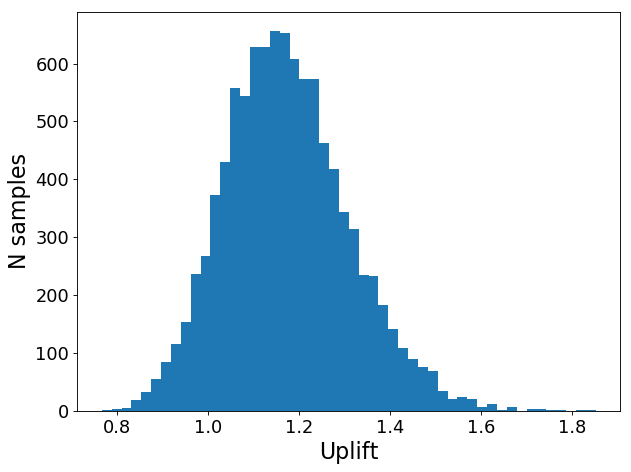

In [11]:
uplift = a_samples / b_samples

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(uplift, bins=50, color='tab:blue')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Uplift', fontsize=20)
plt.ylabel('N samples', fontsize=20)
plt.tight_layout()

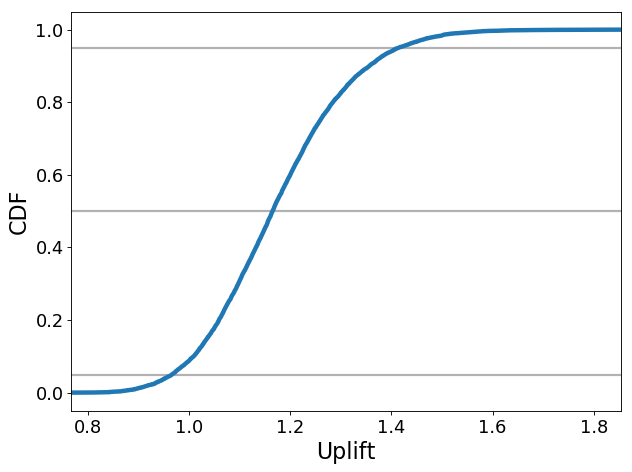

In [12]:
ecdf = ECDF(uplift)

plt.figure(figsize=(8, 6), dpi=80)
plt.hlines(0.95, 0, 10, lw=2.0, alpha=0.3, color='k')
plt.hlines(0.50, 0, 10, lw=2.0, alpha=0.3, color='k')
plt.hlines(0.05, 0, 10, lw=2.0, alpha=0.3, color='k')
plt.plot(ecdf.x, ecdf.y, color='tab:blue', lw=4)
plt.xlim((uplift.min(), uplift.max()))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Uplift', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.tight_layout()